# Objective 
The objective of this notebook is to analyze patterns and trends in ecommerce data through SQL queries. We will then communicate the findings through python visualizations to support strategic planning and stakeholder decision making.

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. The details of the dataset can be found here: https://archive.ics.uci.edu/dataset/352/online+retail.

# 1. Libraries & Functions

## 1.1: Libraries

In [1]:
#Path Creation
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#DataFrame Manipulation and Visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# K-means Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer 
from mpl_toolkits.mplot3d import Axes3D

#SQL 
import sqlite3
from sqlalchemy import create_engine, text

/kaggle/input/ecom-dataset/ecom.xlsx


## 1.2: Functions:

In [2]:
def run_query(query):
    '''
    Takes in a query(str) and executes.
    Returns a pandas DataFrame for better viewing.
    '''
    df_sql = pd.read_sql_query(query, con=engine)
    return df_sql

def execute_multi_query(query_list):
    ''' 
    Takes in a list of SQL queries and executes in order.
    Automatically commits to the server.
    '''
    with engine.connect() as connection:
        # Start a transaction
        with connection.begin():
            for query in query_list:
                connection.execute(text(query))

            # Commit the transaction explicitly if not using `with connection.begin()`
            # connection.commit()  # Uncomment this line if needed
    

# 2. Data Preprocessing

## 2.1: Loading the data

In [3]:
# Loading the dataset
df = pd.read_excel('/kaggle/input/ecom-dataset/ecom.xlsx',dtype={'CustomerID':str,'InvoiceNo':str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


We will be using SQL to query through the table and python to create visualizations, so here we firt export the data to a SQL engine.

In [4]:
# Connect to the sqlite database
engine = create_engine('sqlite://', echo=False)

# Export to SQL table
df.to_sql('sales_data', con =engine, if_exists='replace', index=False)

541909

First we will create a summary table of columns and observe any abnormalities. 

**Note:** The query will check if any columns contain a value of NULL as well as a string of value "NULL".

In [5]:
# Summary Statistics Table
query = """
WITH column_info AS ( 
  SELECT
    column_name,
    data_type,
    COUNT(*) AS total_rows,
    COUNT(CASE WHEN column_value IS NOT NULL AND column_value <> 'NULL' THEN 1 END) AS non_null_count,
    COUNT(CASE WHEN column_value IS NULL OR column_value = 'NULL' THEN 1 END) AS null_count,
    AVG(CASE WHEN data_type IN ('INTEGER', 'REAL', 'FLOAT', 'BIGINT') THEN column_value ELSE NULL END) AS avg_value,
    MIN(CASE WHEN data_type IN ('INTEGER', 'REAL', 'FLOAT', 'BIGINT') THEN column_value ELSE NULL END) AS min_value,
    MAX(CASE WHEN data_type IN ('INTEGER', 'REAL', 'FLOAT', 'BIGINT') THEN column_value ELSE NULL END) AS max_value
  FROM (
    SELECT 
      'InvoiceNo' AS column_name, 'TEXT' AS data_type, InvoiceNo AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'StockCode' AS column_name, 'TEXT' AS data_type, StockCode AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'Description' AS column_name, 'TEXT' AS data_type, Description AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'Quantity' AS column_name, 'BIGINT' AS data_type, Quantity AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'InvoiceDate' AS column_name, 'TEXT' AS data_type, InvoiceDate AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'UnitPrice' AS column_name, 'FLOAT' AS data_type, UnitPrice AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'CustomerID' AS column_name, 'TEXT' AS data_type, CustomerID AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'Country' AS column_name, 'TEXT' AS data_type, Country AS column_value FROM sales_data
  ) AS all_columns
  GROUP BY column_name, data_type
)
SELECT
  column_name,
  data_type,
  100.0 * null_count / total_rows AS null_percentage,
  avg_value,
  min_value,
  max_value
FROM column_info
ORDER BY column_name;


"""
run_query(query)


,column_name,data_type,null_percentage,avg_value,min_value,max_value
0,Country,TEXT,0.000000,NaN,NaN,NaN
1,CustomerID,TEXT,24.926694,NaN,NaN,NaN
2,Description,TEXT,0.268311,NaN,NaN,NaN
3,InvoiceDate,TEXT,0.000000,NaN,NaN,NaN
4,InvoiceNo,TEXT,0.000000,NaN,NaN,NaN
5,Quantity,BIGINT,0.000000,9.552250,-80995.00,80995.0
6,StockCode,TEXT,0.000000,NaN,NaN,NaN
7,UnitPrice,FLOAT,0.000000,4.611114,-11062.06,38970.0


Note that about 25% of the CustomerID column is missing and about 0.27% of the Description column is missing. There are also negative quantity and negative unit price, which represent refunded orders but we will address that later in this notebook.  

## 2.1: Missing Descriptions

We will now take a closer look at rows that are missing description.

In [6]:
query = '''
SELECT * FROM sales_data
WHERE Description IS NULL;
'''
run_query(query)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,None,56,2010-12-01 11:52:00.000000,0.0,None,United Kingdom
1,536545,21134,None,1,2010-12-01 14:32:00.000000,0.0,None,United Kingdom
2,536546,22145,None,1,2010-12-01 14:33:00.000000,0.0,None,United Kingdom
3,536547,37509,None,1,2010-12-01 14:33:00.000000,0.0,None,United Kingdom
4,536549,85226A,None,1,2010-12-01 14:34:00.000000,0.0,None,United Kingdom
...,...,...,...,...,...,...,...,...
1449,581199,84581,None,-2,2011-12-07 18:26:00.000000,0.0,None,United Kingdom
1450,581203,23406,None,15,2011-12-07 18:31:00.000000,0.0,None,United Kingdom
1451,581209,21620,None,6,2011-12-07 18:35:00.000000,0.0,None,United Kingdom
1452,581234,72817,None,27,2011-12-08 10:33:00.000000,0.0,None,United Kingdom


In [7]:
# Summary Statistics Table for data missing Description
query = """
WITH filtered_data AS (
  SELECT * FROM sales_data
  WHERE Description IS NULL
),
column_info AS (
  SELECT
    column_name,
    data_type,
    COUNT(*) AS total_rows,
    COUNT(CASE WHEN column_value IS NOT NULL AND column_value <> 'NULL' THEN 1 END) AS non_null_count,
    COUNT(CASE WHEN column_value IS NULL OR column_value = 'NULL' THEN 1 END) AS null_count
  FROM (
    SELECT 
      'InvoiceNo' AS column_name, 'TEXT' AS data_type, InvoiceNo AS column_value FROM filtered_data
    UNION ALL
    SELECT 
      'StockCode' AS column_name, 'TEXT' AS data_type, StockCode AS column_value FROM filtered_data
    UNION ALL
    SELECT 
      'Description' AS column_name, 'TEXT' AS data_type, Description AS column_value FROM filtered_data
    UNION ALL
    SELECT 
      'Quantity' AS column_name, 'BIGINT' AS data_type, Quantity AS column_value FROM filtered_data
    UNION ALL
    SELECT 
      'InvoiceDate' AS column_name, 'TEXT' AS data_type, InvoiceDate AS column_value FROM filtered_data
    UNION ALL
    SELECT 
      'UnitPrice' AS column_name, 'FLOAT' AS data_type, UnitPrice AS column_value FROM filtered_data
    UNION ALL
    SELECT 
      'CustomerID' AS column_name, 'TEXT' AS data_type, CustomerID AS column_value FROM filtered_data
    UNION ALL
    SELECT 
      'Country' AS column_name, 'TEXT' AS data_type, Country AS column_value FROM filtered_data
  ) AS all_columns
  GROUP BY column_name, data_type
)
SELECT
  column_name,
  data_type,
  null_count,
  100.0 * null_count / total_rows AS null_percentage
FROM column_info
ORDER BY column_name;
"""

run_query(query)

,column_name,data_type,null_count,null_percentage
0,Country,TEXT,0,0.0
1,CustomerID,TEXT,1454,100.0
2,Description,TEXT,1454,100.0
3,InvoiceDate,TEXT,0,0.0
4,InvoiceNo,TEXT,0,0.0
5,Quantity,BIGINT,0,0.0
6,StockCode,TEXT,0,0.0
7,UnitPrice,FLOAT,0,0.0


For all rows that are missing a description, they are also missing a corresponding CustomerID. Because of missing descriptions, we don't know the products associated with these orders. Also, since these rows constitute only ~0.27% of our data, we will remove them here. 

In [8]:
# Execute the DELETE query within a transaction context
delete_query = '''
DELETE FROM sales_data
WHERE Description IS NULL OR Description = 'NULL';
'''

with engine.connect() as connection:
    with connection.begin():  # This handles commit automatically
        connection.execute(text(delete_query))

# Verify the remaining rows count after deletion
row_count_query = '''
SELECT 
    COUNT(*) + 1454 AS Original_rows,
    COUNT(*) AS Remaining_Rows
FROM sales_data;
'''
run_query(row_count_query)

,Original_rows,Remaining_Rows
0,541909,540455


## 2.2: Missing CustomerID

Now let's look at rows that are missing CustomerID.

In [9]:
# Select all rows that are missing CustomerID
query = '''
SELECT * FROM sales_data
WHERE CustomerID IS NULL;
'''
run_query(query)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00.000000,2.51,None,United Kingdom
1,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00.000000,2.51,None,United Kingdom
2,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00.000000,0.85,None,United Kingdom
3,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00.000000,1.66,None,United Kingdom
4,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00.000000,1.66,None,United Kingdom
...,...,...,...,...,...,...,...,...
133621,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00.000000,4.13,None,United Kingdom
133622,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00.000000,4.13,None,United Kingdom
133623,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00.000000,4.96,None,United Kingdom
133624,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00.000000,10.79,None,United Kingdom


From observing the patterns in the original DataFrame, we can recognize that there are rows with repeated InvoiceNo and InvoiceDate values corresponding to each unique CustomerID. This means the similar repetitions in the table above can also be assigned their own unique ID. We will call these rows with missing CustomerID the 'guest' class. 

Hence, we will assign them a unique CustomerID based on repetition in InvoiceNo and InvoiceDate Columns by adding a letter 'g' in front of their index. If only one repetition pair of InvoiceNo and InvoiceDate, that row will count as one unique customer. 

**Note:** In the original DataFrame, sometimes several different (InoviceNo, InvoiceDate) repetitions are assigned to the same CustomerID. We will have no way to distinguish this for the guest DataFrame, meaning we cannot tell if some guest purchases are return customers. 

In [10]:
# Drop temporary table if rerunning the cell
drop_temp_table_query = '''
DROP TABLE IF EXISTS temp_guest_ids;
'''

# Create a temporary table assigning each repeated group to a unique ID = ('g' + row_number)
create_temp_table_query = '''
CREATE TEMPORARY TABLE temp_guest_ids AS
WITH numbered_groups AS (
    SELECT
        InvoiceNo,
        InvoiceDate,
        ROW_NUMBER() OVER (PARTITION BY InvoiceNo, InvoiceDate ORDER BY (SELECT 1)) AS row_num
    FROM sales_data
    WHERE CustomerID IS NULL
)
SELECT
    InvoiceNo,
    InvoiceDate,
    'g' || ROW_NUMBER() OVER (ORDER BY InvoiceNo, InvoiceDate, row_num) AS GuestID
FROM numbered_groups
GROUP BY InvoiceNo, InvoiceDate;
'''

# Update original table's CustomerID column by left joining on InvoiceNo and InvoiceDate where missing ID
update_sales_data_query = '''
UPDATE sales_data
SET CustomerID = (
    SELECT GuestID
    FROM temp_guest_ids
    WHERE sales_data.InvoiceNo = temp_guest_ids.InvoiceNo
    AND sales_data.InvoiceDate = temp_guest_ids.InvoiceDate
)
WHERE CustomerID IS NULL;
'''

# Verifies if successfully updated original data with guest ID
verify_query = '''
SELECT *
FROM sales_data
WHERE CustomerID LIKE 'g%';
'''

# Compile queries into a list and execute
query_list = [drop_temp_table_query, create_temp_table_query, update_sales_data_query]
execute_multi_query(query_list)

# Optional: Verify the changes
run_query(verify_query)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00.000000,2.51,g1,United Kingdom
1,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00.000000,2.51,g1,United Kingdom
2,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00.000000,0.85,g1,United Kingdom
3,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00.000000,1.66,g1,United Kingdom
4,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00.000000,1.66,g1,United Kingdom
...,...,...,...,...,...,...,...,...
133621,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00.000000,4.13,g2083,United Kingdom
133622,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00.000000,4.13,g2083,United Kingdom
133623,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00.000000,4.96,g2083,United Kingdom
133624,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00.000000,10.79,g2083,United Kingdom


In [11]:
# Create summary table for table with updated guest ID
query = '''
WITH column_info AS ( 
  SELECT
    column_name,
    data_type,
    COUNT(*) AS total_rows,
    COUNT(CASE WHEN column_value IS NOT NULL AND column_value <> 'NULL' THEN 1 END) AS non_null_count,
    COUNT(CASE WHEN column_value IS NULL OR column_value = 'NULL' THEN 1 END) AS null_count
  FROM (
    SELECT 
      'InvoiceNo' AS column_name, 'TEXT' AS data_type, InvoiceNo AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'StockCode' AS column_name, 'TEXT' AS data_type, StockCode AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'Description' AS column_name, 'TEXT' AS data_type, Description AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'Quantity' AS column_name, 'BIGINT' AS data_type, Quantity AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'InvoiceDate' AS column_name, 'TEXT' AS data_type, InvoiceDate AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'UnitPrice' AS column_name, 'FLOAT' AS data_type, UnitPrice AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'CustomerID' AS column_name, 'TEXT' AS data_type, CustomerID AS column_value FROM sales_data
    UNION ALL
    SELECT 
      'Country' AS column_name, 'TEXT' AS data_type, Country AS column_value FROM sales_data
  ) AS all_columns
  GROUP BY column_name, data_type
)
SELECT
  column_name,
  data_type,
  100.0 * null_count / total_rows AS null_percentage
FROM column_info
ORDER BY column_name;
'''
run_query(query)

,column_name,data_type,null_percentage
0,Country,TEXT,0.0
1,CustomerID,TEXT,0.0
2,Description,TEXT,0.0
3,InvoiceDate,TEXT,0.0
4,InvoiceNo,TEXT,0.0
5,Quantity,BIGINT,0.0
6,StockCode,TEXT,0.0
7,UnitPrice,FLOAT,0.0


Awesome. Now that we have successfully recovered about 25% of the CustomerID column, we can create a new column "CustomerType" to assign them to their respective group. We will also add a new column "Revenue" that will be useful later.

In [12]:
# Alter the table to add two empty columns
alter_type = '''
ALTER TABLE sales_data 
ADD CustomerType TEXT;
'''

alter_revenue = '''
ALTER TABLE sales_data
ADD Revenue FLOAT;
'''

# Add values to the two new columns
update_type = '''
UPDATE sales_data
SET CustomerType = CASE 
    WHEN CustomerID LIKE 'g%' THEN 'guest'
    ELSE 'return'
END;
'''

update_revenue = '''
UPDATE sales_data
SET Revenue = Quantity * UnitPrice;
'''

# Compile into list of queries and execute
new_cols_lst = [alter_type, alter_revenue, update_type, update_revenue]
execute_multi_query(new_cols_lst)

In [30]:
# Check out updated data with two new columns
df = run_query('SELECT * FROM SALES_DATA')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00.000000,2.55,17850,United Kingdom,return,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00.000000,3.39,17850,United Kingdom,return,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00.000000,2.75,17850,United Kingdom,return,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00.000000,3.39,17850,United Kingdom,return,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00.000000,3.39,17850,United Kingdom,return,20.34
...,...,...,...,...,...,...,...,...,...,...
540450,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00.000000,0.85,12680,France,return,10.20
540451,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00.000000,2.10,12680,France,return,12.60
540452,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00.000000,4.15,12680,France,return,16.60
540453,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00.000000,4.15,12680,France,return,16.60


# 3. Customer Segmentation Using K-means Clustering

#### Question: What are the different segments of customers based on their purchasing behavior?
Within this section, we will attempt to segment customers and discover insights about the behavior of each segment.

## 3.1: Feature Engineering & Standardization

We will now create some useful features from the existing data columns.

**Core Features:**

- **Total Revenue:** Sum of all purchases made by the customer. Indicates the overall value of the customer to the business.
- **Frequency:** Number of transactions or purchases made by the customer. Reflects how often a customer buys.
- **Recency:** Time since the last purchase. Helps understand customer loyalty and engagement.
- **Average Order Value (AOV):** Total revenue divided by the number of orders. Shows how much a customer spends per transaction.

**Additional Features:**

- **Total Number of Products Purchased:** The total quantity of products bought. Provides insight into buying behavior.
- **Average Quantity per Order:** Total quantity divided by the number of orders. Indicates how much the customer buys in each order.
- **Customer Lifetime:** Total time a customer has been with the company. Can help in understanding long-term value.
- **Product Diversity:** Number of unique products purchased. Shows how diverse the customer’s purchasing habits are.

In [31]:
# Convert InvoiceDate from string to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


# Total Revenue
df_total_revenue = df.groupby('CustomerID')['Revenue'].sum().reset_index(name='TotalRevenue')

# Frequency
df_frequency = df.groupby('CustomerID')['InvoiceNo'].count().reset_index(name='Frequency')

# Recency
df_last_purchase = df.groupby('CustomerID')['InvoiceDate'].max().reset_index(name='LastPurchaseDate')
df_last_purchase['Recency'] = (df['InvoiceDate'].max() - df_last_purchase['LastPurchaseDate']).dt.days

# Average Order Value (AOV)
df_aov = df.groupby('CustomerID')['Revenue'].sum() / df.groupby('CustomerID')['InvoiceNo'].count()
df_aov = df_aov.reset_index(name='AOV')

# Total Number of Products Purchased
df_total_quantity = df.groupby('CustomerID')['Quantity'].sum().reset_index(name='TotalQuantity')

# Average Quantity per Order
df_avg_quantity_per_order = df.groupby('CustomerID')['Quantity'].sum() / df.groupby('CustomerID')['InvoiceNo'].count()
df_avg_quantity_per_order = df_avg_quantity_per_order.reset_index(name='AvgQuantityPerOrder')

# Customer Lifetime
df_first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index(name='FirstPurchaseDate')
df_first_purchase['CustomerLifetime'] = (df['InvoiceDate'].max() - df_first_purchase['FirstPurchaseDate']).dt.days

# Product Diversity
df_product_diversity = df.groupby('CustomerID')['StockCode'].nunique().reset_index(name='ProductDiversity')

# Merge all features into one DataFrame
df_features = pd.merge(df_total_revenue, df_frequency, on='CustomerID')
df_features = pd.merge(df_features, df_last_purchase[['CustomerID', 'Recency']], on='CustomerID')
df_features = pd.merge(df_features, df_aov, on='CustomerID')
df_features = pd.merge(df_features, df_total_quantity, on='CustomerID')
df_features = pd.merge(df_features, df_avg_quantity_per_order, on='CustomerID')
df_features = pd.merge(df_features, df_first_purchase[['CustomerID', 'CustomerLifetime']], on='CustomerID')
df_features = pd.merge(df_features, df_product_diversity, on='CustomerID')


In [32]:
df_features.head()

,CustomerID,TotalRevenue,Frequency,Recency,AOV,TotalQuantity,AvgQuantityPerOrder,CustomerLifetime,ProductDiversity
0,12346,0.00,2,325,0.000000,0,0.000000,325,1
1,12347,4310.00,182,1,23.681319,2458,13.505495,366,103
2,12348,1797.24,31,74,57.975484,2341,75.516129,357,22
3,12349,1757.55,73,18,24.076027,631,8.643836,18,73
4,12350,334.40,17,309,19.670588,197,11.588235,309,17


In [33]:
col_names = ['TotalRevenue', 'Frequency', 'Recency', 
                        'AOV', 'TotalQuantity', 'AvgQuantityPerOrder', 
                        'CustomerLifetime', 'ProductDiversity']
sd=StandardScaler()
features = df_features[col_names]
scaler = sd.fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head().style.background_gradient(cmap='Blues').set_properties(**{'font-family': 
                                                                                'Segoe UI'})

,TotalRevenue,Frequency,Recency,AOV,TotalQuantity,AvgQuantityPerOrder,CustomerLifetime,ProductDiversity
0,-0.214281,-0.394298,1.862303,0.024762,-0.203271,0.015902,0.997843,-0.609153
1,0.414826,0.499646,-1.044384,0.059715,0.435954,0.057559,1.340108,0.437794
2,0.048052,-0.250274,-0.389482,0.110334,0.405527,0.248829,1.264977,-0.393605
3,0.042259,-0.041687,-0.891872,0.060298,-0.039174,0.042564,-1.564969,0.129868
4,-0.165470,-0.319803,1.718763,0.053796,-0.152040,0.051646,0.864276,-0.444926


## 3.2: Building the model

### 3.2.1: Elbow Method to determine optimal number of clusters

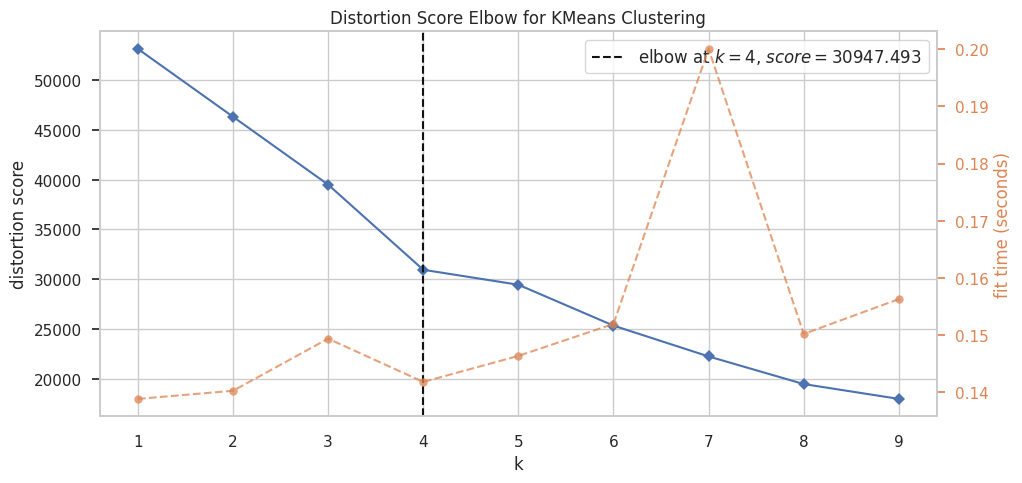

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
# Create an instance of the KMeans model
model = KMeans(n_init='auto')

# Create an instance of the KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(1, 10), size=(1080, 500))

# Fit the visualizer to the data
visualizer.fit(scaled_features)

# Show the visualizer
visualizer.show()

****Using the elbow method, we can observe that the optimal number of clusters is k = 4. Now we will build a clustering model using k-means with num_clusters = 4.****

### 3.2.2: Silhouette Score for validation

In [38]:
# Build a K-means model with 4 clusters
kmeans = KMeans(n_clusters = 4, init='k-means++',random_state=42, n_init='auto')
kmeans.fit(scaled_features)

# Print the silhouette score of this model
print("silhouette_score is :",silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

silhouette_score is : 0.3442342550287783


The silhouette score is a measure of how similar each point is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters. 

### 3.2.3: Visualization of base model clusters at clusters k = 4

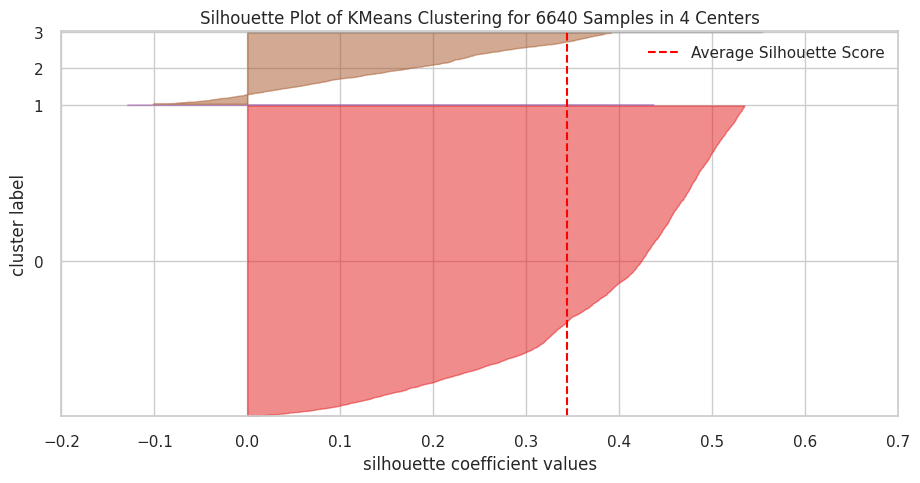

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 6640 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
# Instantiate the KMeans model again for visualization (same parameters)
kmeans_visualize = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init='auto')

# Instantiate the SilhouetteVisualizer with the KMeans model
visualizer = SilhouetteVisualizer(kmeans_visualize, size=(1080, 500))

# Fit the visualizer to the scaled features
visualizer.fit(scaled_features)

# Show the silhouette plot
visualizer.show()

The silhouette score of this model is 0.344, which isn't bad, but we can do better. 

This is a silhouette diagram. The shapes height indicates number of instances the cluster contains, and its width represents the sorted silhouette coefficients of the instances in the cluster (the wider the better). The dashed line indicates the mean silhouette coefficient.

From the visualization, there are only two distinct regions. This suggests that these clusters might be overlapping or not distinctly separated. This overlap could indicate that these clusters are similar in terms of the features and might not represent very different segments of the data. 

It might be worth trying different numbers of clusters or revisiting feature engineering.


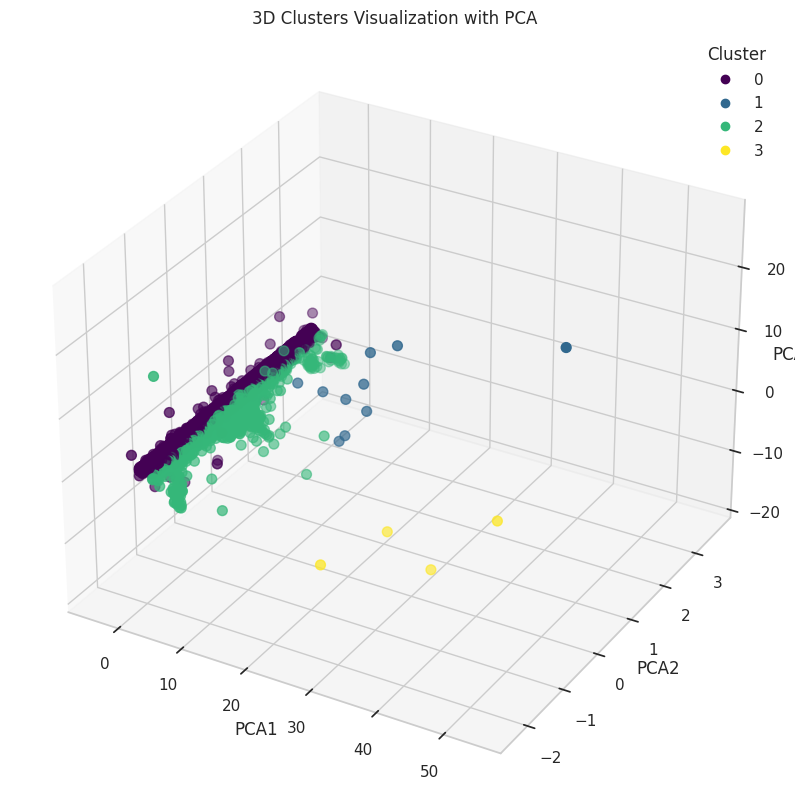

In [40]:
# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Create a DataFrame with PCA features and cluster labels
df_pca_3d = pd.DataFrame(pca_features, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca_3d['Cluster'] = kmeans.labels_

# Plot the clusters
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca_3d['PCA1'], df_pca_3d['PCA2'], df_pca_3d['PCA3'], c=df_pca_3d['Cluster'], cmap='viridis', s=50)
ax.set_title('3D Clusters Visualization with PCA')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()

From the visualization of the clusters, majority of the data points are grouped into two distinct clusters. This might indicate that there are two primary types of customer behaviors or purchasing patterns, which could be the guests and return customer types.

### 3.2.4: New K-means Model with k = 2

In [41]:
# Build a K-means model with 2 clusters
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42, n_init='auto')
kmeans.fit(scaled_features)

# Print the silhouette score of this model
print("silhouette_score is :", silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

silhouette_score is : 0.9131885495763058


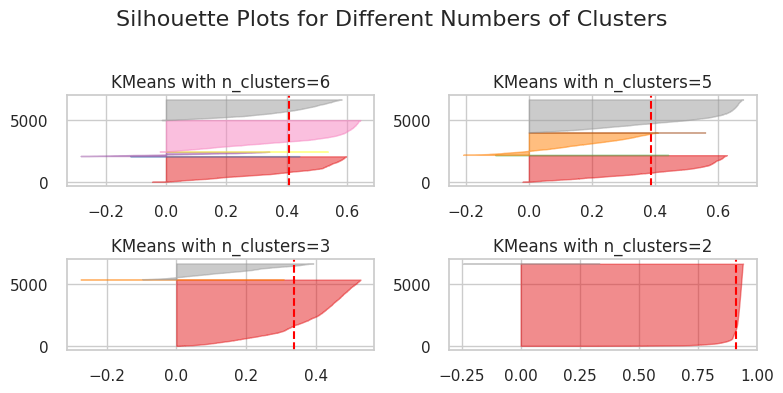

In [42]:
# Define the number of clusters to visualize
n_clusters_list = [6, 5, 3, 2]

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Two rows, two columns
fig.suptitle('Silhouette Plots for Different Numbers of Clusters', fontsize=16)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through the number of clusters and plot the silhouette plots
for ax, n_clusters in zip(axs, n_clusters_list):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init='auto')
    visualizer = SilhouetteVisualizer(kmeans, ax=ax, size=(800, 400))
    
    # Fit the visualizer to the scaled features
    visualizer.fit(scaled_features)
    
    # Set the title for each subplot
    ax.set_title(f'KMeans with n_clusters={n_clusters}')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for suptitle
plt.show()

The new Silhouette Score is 0.91, which is a 168% increase from 0.34.

The silhouette plot for k=2 shows one large region. This means that the majority of the data points are well-clustered, and they are close to the center of their respective clusters. This suggests that the clustering solution is quite good, and most points are assigned to clusters where they are relatively similar to other points in the same cluster.

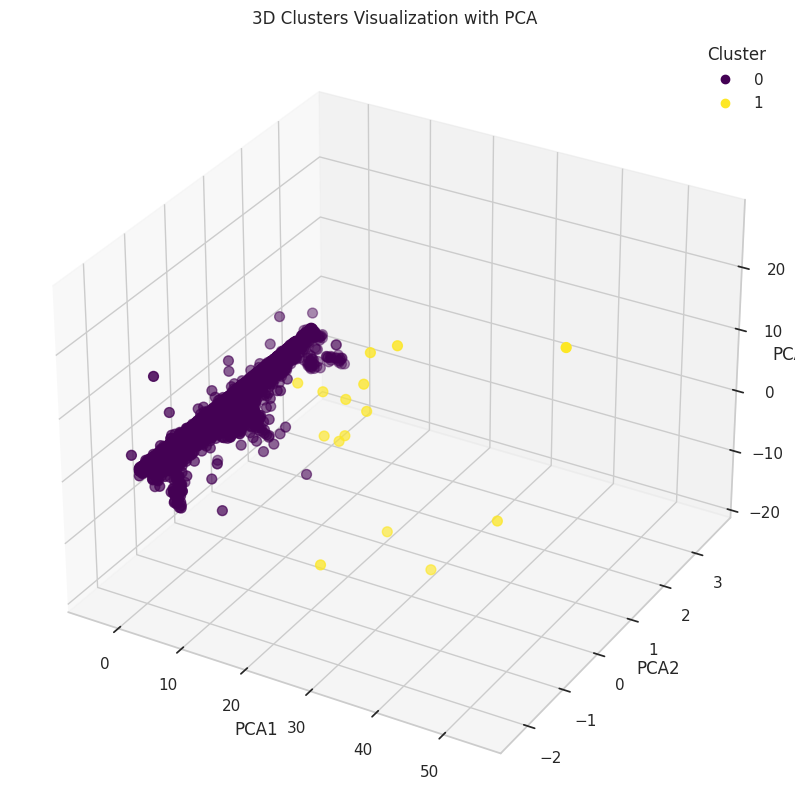

In [43]:
# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Create a DataFrame with PCA features and cluster labels
df_pca_3d = pd.DataFrame(pca_features, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca_3d['Cluster'] = kmeans.labels_

# Plot the clusters
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca_3d['PCA1'], df_pca_3d['PCA2'], df_pca_3d['PCA3'], c=df_pca_3d['Cluster'], cmap='viridis', s=50)
ax.set_title('3D Clusters Visualization with PCA')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()

## 3.3: Analyze Cluster Characteristics

In [44]:
# Add cluster labels to the original data
scaled_features['Cluster'] = kmeans.labels_

# Calculate the mean of features for each cluster
cluster_profiles = scaled_features.groupby('Cluster').mean()
print(cluster_profiles)


         TotalRevenue  Frequency   Recency       AOV  TotalQuantity  \
Cluster                                                               
0           -0.034854  -0.026561  0.002309 -0.000514      -0.035083   
1           15.393847  11.731221 -1.019862  0.226824      15.494929   

         AvgQuantityPerOrder  CustomerLifetime  ProductDiversity  
Cluster                                                           
0                  -0.000506         -0.002690         -0.015954  
1                   0.223580          1.188176          7.046565  


# 4. Product Analysis

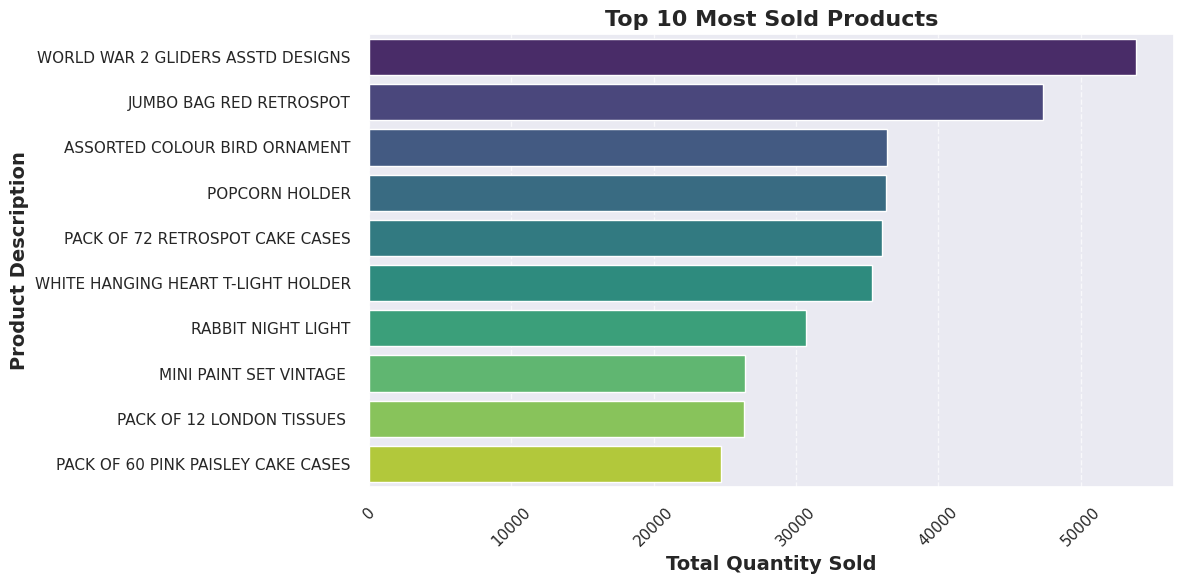

In [45]:
# Query to get the most sold products by quantity
query = '''
SELECT Description, SUM(Quantity) AS TotalQuantity
FROM sales_data
GROUP BY Description
ORDER BY TotalQuantity DESC
LIMIT 10;
'''

# Fetch data from the database
df_sold_products = pd.read_sql_query(query, con=engine)

# Set a theme and color palette
sns.set_theme(style="darkgrid")
palette = sns.color_palette("viridis", n_colors=len(df_sold_products))

# Set font properties
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.serif'] = ['Georgia']  

# Plotting
plt.figure(figsize=(12, 6))

# Create a bar plot
sns.barplot(
    x='TotalQuantity',
    y='Description',
    data=df_sold_products,
    palette=palette
)

# Add labels and title
plt.title('Top 10 Most Sold Products', fontsize=16, weight='bold')
plt.xlabel('Total Quantity Sold', fontsize=14, weight='bold')
plt.ylabel('Product Description', fontsize=14, weight='bold')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout to avoid overlap
plt.tight_layout()

# Show plot
plt.show()

In [46]:
query = '''
SELECT 
    Description AS Product,
    SUM(Quantity * UnitPrice) AS TotalRevenue
FROM sales_data
GROUP BY Description
ORDER BY TotalRevenue DESC
LIMIT 10;
'''

revenue_by_product_sorted = run_query(query)
revenue_by_product_sorted


,Product,TotalRevenue
0,DOTCOM POSTAGE,206245.48
1,REGENCY CAKESTAND 3 TIER,164762.19
2,WHITE HANGING HEART T-LIGHT HOLDER,99668.47
3,PARTY BUNTING,98302.98
4,JUMBO BAG RED RETROSPOT,92356.03
5,RABBIT NIGHT LIGHT,66756.59
6,POSTAGE,66230.64
7,PAPER CHAIN KIT 50'S CHRISTMAS,63791.94
8,ASSORTED COLOUR BIRD ORNAMENT,58959.73
9,CHILLI LIGHTS,53768.06


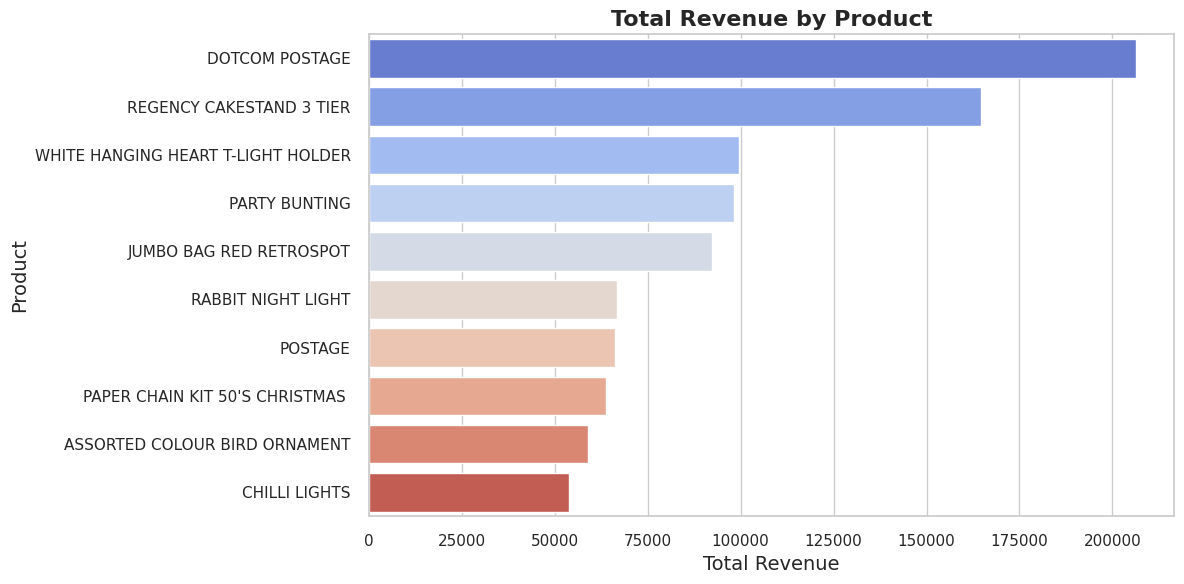

In [47]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot the data
plt.figure(figsize=(12, 6))
plot = sns.barplot(x='TotalRevenue', y='Product', data=revenue_by_product_sorted, palette='coolwarm')
plot.set_title('Total Revenue by Product', fontsize=16, fontweight='bold')
plot.set_xlabel('Total Revenue', fontsize=14)
plot.set_ylabel('Product', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()